### 1. Import libraries

test **test** __test__ *test* 
1. test
1. test
1. test

``` 
function square(n) {
  return n * n;
}
```

Alexnet [paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networ)
VGG16 [paper](https://arxiv.org/abs/1409.1556)
LeNet5 [Link](http://yann.lecun.com/exdb/lenet/)


### 1. Import libraries

In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model 
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [ ]:
import data
import models     
from validation import recall_m, precision_m, f1_m, auc

### 2. Check a device

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13543279120346149363
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13278150456813171124
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### 3. Import the data 

-  data_train: Input data for the base model training. The number of data is 15750 and the size of each is 50x50x2.   
-  label_train: The label for the training. The number of label is also 15750. 

-  data_test: Input data for testing. The number of data is 3150 and the size of each is 50x50x2.   
-  label_test: The label for the testing. The number of label is also 3150. 

In [3]:
data_train,label_train=data.data_train()
data_test,label_test=data.testing()
#data_marm,label_marm,data_marml_tl,label_marm_tl=data.marmousi()

In [4]:
print('train input size =',data_train.shape)
print('train label size =',label_train.shape)

print('test input size =',data_test.shape)
print('test label size =',label_test.shape)

#print('marmousi input size =',data_marm.shape)
#print('marmousi label size =',label_marm.shape)

train input size = (15750, 50, 50, 2)
train label size = (15750, 40)
test input size = (3150, 50, 50, 2)
test label size = (3150, 40)


### 4. Defining the CNN model

models library includes three CNN models:
-  models.lenet()
-  models.alexnet()
-  models.vgg16()

Each one have four variables: 
-  in_shape: input shape. Default is (50,50,2) 
-  n_classes: the number of class. Default is 40 
-  fc1: the length of the first fully connected layers. 
-  fc2: the length of the second fully connected layers.

In [8]:
model=models.vgg16(in_shape=(50,50,2), n_classes=40, fc1=1024, fc2=512)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1216      
_________________________________________________________________
batch_normalization_17 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 50, 50, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
__________

In [6]:
#### for using multi gpu #####
#from multi_gpu import multi_gpu_model
#model = multi_gpu_model(model, gpus=2)

In [6]:
## Learning rate: decay

def learning_rate_decay(epoch):
    initial_lr = 1e-4
    max_epoch = 20

    if epoch < max_epoch:
        lr = initial_lr
    else:
        idecay = (epoch // max_epoch)
        lr = initial_lr/(idecay * 2)
    return lr

###### declare check point ####### 
lr_sched = LearningRateScheduler(learning_rate_decay)
model_checkpoint = ModelCheckpoint('CNN.hdf5', monitor='loss', verbose=0, save_best_only=True)

### 5. Model compile and training

-  loss: cross-entropy 
\begin{equation}\label{eq:cost_ce}
    J\left(\phi_{1}, \phi_{2}\right)=-\sum_{i=1}^{N} \phi_{1}(i) \log \left(\phi_{2}(i)\right)
\end{equation}

-  optimizer: Adaptive Moment Estimation (Adam) optimizer [[paper](https://arxiv.org/pdf/1412.6980.pdf%20%22%20entire%20document)]

In [7]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

In [9]:
history=model.fit(data_train, label_train, 
                  validation_data=(data_test, label_test), 
                  nb_epoch=3, 
                  batch_size=315, 
                  callbacks=[model_checkpoint,lr_sched ],
                  verbose=1)

C:\Users\mjmr0\Anaconda3\envs\mj\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 15750 samples, validate on 3150 samples
Epoch 1/3
15750/15750 [==============================] - 76s 5ms/step - loss: 3.1445 - acc: 0.2232 - val_loss: 3.1092 - val_acc: 0.1517
Epoch 2/3
15750/15750 [==============================] - 80s 5ms/step - loss: 2.6964 - acc: 0.2812 - val_loss: 2.6784 - val_acc: 0.2133
Epoch 3/3
15750/15750 [==============================] - 75s 5ms/step - loss: 2.3694 - acc: 0.3212 - val_loss: 2.2675 - val_acc: 0.2235


### 6. Testing

In [10]:
prediction = model.predict(data_test)

In [11]:
prediction_classes=np.argmax(prediction,axis=1)
true_classes=np.argmax(label_test,axis=1)

In [12]:
predicted_vel=np.zeros([70,45])
true_vel=np.zeros([70,45])
for i in range(70):
    predicted_vel[i,:]=prediction_classes[i*45:i*45+45]
    true_vel[i,:]=true_classes[i*45:i*45+45]

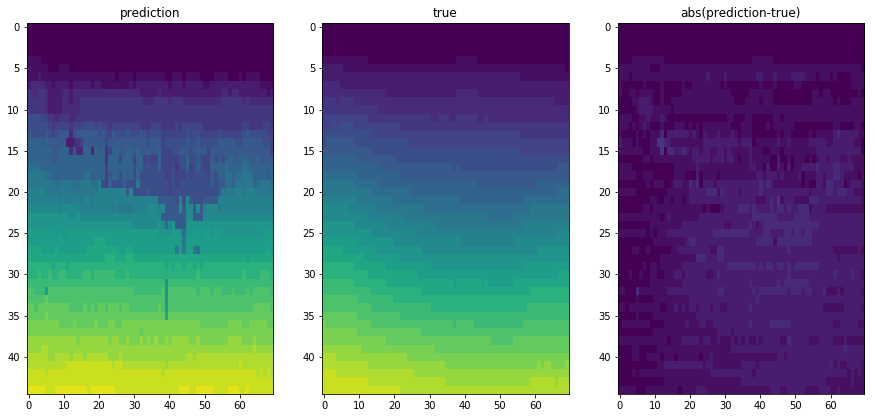

In [13]:
n=0
x=25
fig = plt.figure(figsize=[15,15])
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(predicted_vel.T,aspect='auto',vmin=n,vmax=x)
ax1.title.set_text('prediction')
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(true_vel.T,aspect='auto',vmin=n,vmax=x)
ax2.title.set_text('true')
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(np.abs(predicted_vel.T-true_vel.T),aspect='auto',vmin=n,vmax=x)
ax3.title.set_text('abs(prediction-true)')